In [12]:
import pandas as pd
import zipfile
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings("ignore")

In [13]:
df_2021 = pd.read_csv(zipfile.ZipFile('raw_data/TRK_13139_FY2021.zip', 'r').open('TRK_13139_FY2021.csv'))
df_2022 = pd.read_csv(zipfile.ZipFile('raw_data/TRK_13139_FY2022.zip', 'r').open('TRK_13139_FY2022.csv'))
df_2023 = pd.read_csv(zipfile.ZipFile('raw_data/TRK_13139_FY2023.zip', 'r').open('TRK_13139_FY2023.csv'))
df_2024_multi = pd.read_csv(zipfile.ZipFile('raw_data/TRK_13139_FY2024_multi_reg.zip', 'r').open('TRK_13139_FY2024_multi_reg.csv'))
df_2024_single = pd.read_csv(zipfile.ZipFile('raw_data/TRK_13139_FY2024_single_reg.zip', 'r').open('TRK_13139_FY2024_single_reg.csv'))

# Shape of each dataframe

In [14]:
df_2021.shape, df_2022.shape, df_2023.shape, df_2024_multi.shape, df_2024_single.shape

((269424, 56), (301447, 56), (474421, 56), (408891, 56), (350103, 56))

# Verify that the datasets have the same column names

In [15]:
cols_2021 = set(df_2021.columns)
cols_2022 = set(df_2022.columns)
cols_2023 = set(df_2023.columns)
cols_2024_multi = set(df_2024_multi.columns)
cols_2024_single = set(df_2024_single.columns)

# Check if all column sets are equal
assert(cols_2021 == cols_2022 == cols_2023 == cols_2024_multi == cols_2024_single)

# Q: Which factors contribute most to the approval / denial of a H1B petition once it has been selected from the lottery?
Applicants are only approved or denied from an H1B petition after they were selected from the lottery. Therefore we are only interested in observations that have the **"Selected"** status type.

In [16]:
selected_status_condition = lambda df: df['status_type'] == 'SELECTED'

df_2021 = df_2021[selected_status_condition]
df_2022 = df_2022[selected_status_condition]
df_2023 = df_2023[selected_status_condition]
df_2024_multi = df_2024_multi[selected_status_condition]
df_2024_single = df_2024_single[selected_status_condition]

# Print new shapes of each dataset after filtering
df_2021.shape, df_2022.shape, df_2023.shape, df_2024_multi.shape, df_2024_single.shape

((124368, 56), (131896, 56), (127563, 56), (103060, 56), (85304, 56))

# Combine H1B datasets from 2021-2024

In [17]:
entire_df = pd.concat([df_2021, df_2022, df_2023, df_2024_multi, df_2024_single]).reset_index(drop = True)

# Cast lottery year column as int, and employer names to uppercase
entire_df['lottery_year'] = entire_df['lottery_year'].astype(int)
entire_df['employer_name'] = entire_df['employer_name'].str.upper()

# Feature preprocessing - since the following processes are deterministic and does not depend on dataset-specific statistics we can perform this on the entire dataset instead of transforming each individual split based on the attributes of the training data

### Calculate the beneficiary's age from rec_date and their ben_year_of_birth

In [18]:
# Fill in missing rec_dates with the lottery year
entire_df['rec_date'] = (entire_df['rec_date']
    .fillna(entire_df['lottery_year'])
    .astype(str).str.slice(-4)
    .astype(int)
)

# Calculate the beneficiary's age
entire_df['ben_age_in_years'] = (
    entire_df['rec_date'] 
    - entire_df['ben_year_of_birth'].astype(int)
)

### Map nationalities to their world regions, and worksite states to US geographical regions.

In [19]:
def map_countries_to_world_regions(data: pd.DataFrame) -> pd.DataFrame:
    """
    Maps country codes from the 'country_of_nationality' column to a world region such as North America, South America, etc.
    """
    country_region_mapping = {
        "CAN": "North America", "MEX": "North America", "USA": "North America", "BHS": "North America", "BRB": "North America", 
        "BLZ": "North America", "CUB": "North America", "DOM": "North America", "GRD": "North America", "HTI": "North America", 
        "HND": "North America", "JAM": "North America", "KNA": "North America", "LCA": "North America", "VCT": "North America", 
        "TTO": "North America", "PAN": "North America", "SLV": "North America", "NIC": "North America", "CRI": "North America", 
        "GTM": "North America", "ATG": "North America", "DMA": "North America",
        
        "ARG": "South America", "BOL": "South America", "BRA": "South America", "CHL": "South America", "COL": "South America", 
        "ECU": "South America", "GUY": "South America", "PRY": "South America", "PER": "South America", "SUR": "South America", 
        "URY": "South America", "VEN": "South America", 

        "ALB": "Europe", "AND": "Europe", "AUT": "Europe", "BLR": "Europe", "BEL": "Europe", "BIH": "Europe", "BGR": "Europe", 
        "HRV": "Europe", "CYP": "Europe", "CZE": "Europe", "DNK": "Europe", "EST": "Europe", "FIN": "Europe", "FRA": "Europe", 
        "DEU": "Europe", "GRC": "Europe", "HUN": "Europe", "ISL": "Europe", "IRL": "Europe", "ITA": "Europe", "XKS": "Europe", 
        "LVA": "Europe", "LIE": "Europe", "LTU": "Europe", "LUX": "Europe", "MLT": "Europe", "MDA": "Europe", "MCO": "Europe", 
        "MNE": "Europe", "NLD": "Europe", "MKD": "Europe", "NOR": "Europe", "POL": "Europe", "PRT": "Europe", "ROU": "Europe", 
        "RUS": "Europe", "SRB": "Europe", "SVK": "Europe", "SVN": "Europe", "ESP": "Europe", "SWE": "Europe", "CHE": "Europe", 
        "UKR": "Europe", "GBR": "Europe", "TUR": "Europe", "XKX": "Europe",

        "DZA": "Africa", "AGO": "Africa", "BEN": "Africa", "BWA": "Africa", "BFA": "Africa", "BDI": "Africa", "CMR": "Africa", 
        "CPV": "Africa", "CAF": "Africa", "TCD": "Africa", "CIV": "Africa", "COD": "Africa", "EGY": "Africa", "GNQ": "Africa", 
        "ERI": "Africa", "SWZ": "Africa", "ETH": "Africa", "GAB": "Africa", "GMB": "Africa", "GHA": "Africa", "GIN": "Africa", 
        "GNB": "Africa", "KEN": "Africa", "LSO": "Africa", "LBR": "Africa", "LBY": "Africa", "MDG": "Africa", "MWI": "Africa", 
        "MLI": "Africa", "MRT": "Africa", "MUS": "Africa", "MAR": "Africa", "MOZ": "Africa", "NAM": "Africa", "NER": "Africa", 
        "NGA": "Africa", "RWA": "Africa", "SEN": "Africa", "SYC": "Africa", "SLE": "Africa", "SOM": "Africa", "ZAF": "Africa", 
        "SSD": "Africa", "SDN": "Africa", "TZA": "Africa", "TGO": "Africa", "TUN": "Africa", "UGA": "Africa", "ZMB": "Africa", 
        "ZWE": "Africa", "COG": "Africa",

        "AFG": "Asia", "ARM": "Asia", "AZE": "Asia", "BHR": "Asia", "BGD": "Asia", "BTN": "Asia", "BRN": "Asia", "KHM": "Asia", 
        "CHN": "Asia", "GEO": "Asia", "HKG": "Asia", "IND": "Asia", "IDN": "Asia", "IRN": "Asia", "IRQ": "Asia", "ISR": "Asia", 
        "JPN": "Asia", "JOR": "Asia", "KAZ": "Asia", "KWT": "Asia", "KGZ": "Asia", "LAO": "Asia", "LBN": "Asia", "MAC": "Asia", 
        "MYS": "Asia", "MNG": "Asia", "MMR": "Asia", "NPL": "Asia", "PRK": "Asia", "OMN": "Asia", "PAK": "Asia", "PSE": "Asia", 
        "PHL": "Asia", "QAT": "Asia", "SAU": "Asia", "SGP": "Asia", "KOR": "Asia", "LKA": "Asia", "SYR": "Asia", "TWN": "Asia", 
        "TJK": "Asia", "THA": "Asia", "TKM": "Asia", "ARE": "Asia", "UZB": "Asia", "VNM": "Asia", "YEM": "Asia", 

        "AUS": "Oceania", "FJI": "Oceania", "NZL": "Oceania", "PNG": "Oceania", "WSM": "Oceania", "TUV": "Oceania", 

        "XXA": "Unknown", "AX1": "Unknown", "undefined": "Unknown"
    }

    result_df = data.copy()
    result_df['world_region_nationality'] = result_df['country_of_nationality'].map(country_region_mapping)
    # result_df = result_df.drop(columns = 'country_of_nationality')
    return result_df

def map_states_to_geographical_regions(data: pd.DataFrame) -> pd.DataFrame:
    """
    Maps US state/territory abbreviations from the 'worksite_state' column to a US geographical region such as Northeast, Midwest, etc.
    """
    state_region_mapping = {
        # **Northeast**
        'CT': 'Northeast', 'ME': 'Northeast', 'MA': 'Northeast', 'NH': 'Northeast',
        'RI': 'Northeast', 'VT': 'Northeast', 'NJ': 'Northeast', 'NY': 'Northeast',
        'PA': 'Northeast',

        # **Midwest**
        'IL': 'Midwest', 'IN': 'Midwest', 'MI': 'Midwest', 'OH': 'Midwest', 'WI': 'Midwest',
        'IA': 'Midwest', 'KS': 'Midwest', 'MN': 'Midwest', 'MO': 'Midwest', 'NE': 'Midwest',
        'ND': 'Midwest', 'SD': 'Midwest',

        # **South**
        'DE': 'South', 'FL': 'South', 'GA': 'South', 'MD': 'South', 'NC': 'South',
        'SC': 'South', 'VA': 'South', 'DC': 'South', 'WV': 'South', 'AL': 'South',
        'KY': 'South', 'MS': 'South', 'TN': 'South', 'TS': 'South', 'AR': 'South', 
        'LA': 'South', 'OK': 'South', 'TX': 'South',

        # **West**
        'AZ': 'West', 'CO': 'West', 'ID': 'West', 'MT': 'West', 'NV': 'West', 'NM': 'West',
        'UT': 'West', 'WY': 'West', 'AK': 'West', 'CA': 'West', 'HI': 'West', 'OR': 'West',
        'WA': 'West',

        # **US Territories (Grouped Separately)**
        'PR': 'US Territory', 'GU': 'US Territory', 'VI': 'US Territory', 'AS': 'US Territory',

        # **Unknown**
        'XX': "Unknown" 
    }

    result_df = data.copy()

    # Replace missing worksite states with the corresponding value from the employer's state.
    result_df['WORKSITE_STATE'] = entire_df['WORKSITE_STATE'].fillna(entire_df['state'])

    # Map the worksite states to their US region
    result_df['WORKSITE_REGION'] = result_df['WORKSITE_STATE'].map(state_region_mapping)
    result_df = result_df.drop(columns = 'WORKSITE_STATE')
    return result_df

entire_df = map_states_to_geographical_regions(map_countries_to_world_regions(entire_df))
entire_df['world_region_nationality'].unique(), entire_df['WORKSITE_REGION'].unique()

(array(['North America', 'Asia', 'Africa', 'Europe', 'South America',
        'Oceania', 'Unknown'], dtype=object),
 array(['West', 'Northeast', 'South', 'Midwest', 'US Territory', 'Unknown'],
       dtype=object))

### Standardize all wage amounts to annual.

In [20]:
def standardize_wage_to_annual(df):
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Cast as float, fill missing wage values with compensation paid
    df_copy['WAGE_AMT'] = (df_copy['WAGE_AMT']
        .fillna(df_copy['BEN_COMP_PAID'])
        .astype(float)
        # .dropna(subset = 'WAGE_AMT')
    )

    # Define the multiplication factors for each unit
    wage_multipliers = {
        "HOUR": 40 * 50,  # 40 hours/week * 50 weeks/year
        "MONTH": 12,      # 12 months/year
        "WEEK": 50        # 50 weeks/year
    }

    # Apply the multipliers based on the WAGE_UNIT
    df_copy['WAGE_AMT_ANNUAL'] = df_copy.apply(
        lambda row: row['WAGE_AMT'] * wage_multipliers.get(row['WAGE_UNIT'], 1) 
        if row['WAGE_UNIT'] in wage_multipliers else row['WAGE_AMT'], axis=1
    ).astype(float)

    
    # Impute missing annual wages with median wage by lottery year
    if df_copy['WAGE_AMT_ANNUAL'].isna().sum():
        median_wages_by_lottery_year = df_copy.groupby('lottery_year')['WAGE_AMT_ANNUAL'].transform('median')
        df_copy['WAGE_AMT_ANNUAL'] = df_copy['WAGE_AMT_ANNUAL'].fillna(median_wages_by_lottery_year)

    return df_copy

entire_df = standardize_wage_to_annual(entire_df)

# Ensure that there are no missing annual wage values
assert(entire_df['WAGE_AMT_ANNUAL'].isna().sum() == 0)

### Transform annual wages that are greater than 1 million dollars to have at most 6 figures (digits)

In [21]:
def scale_to_six_digits_with_decimal(x):
    """
    Scales annual wages greater than 999,999 to retain only six significant digits 
    by shifting the decimal point appropriately.

    Arguments:
        x (float or int): A numeric value to be scaled.

    Returns:
        float: The input value scaled such that it has six digits to the left 
               of the decimal point (with remaining digits shifted to the right).
               Values smaller than 1,000,000 are left unchanged.
    """
    if x == 0:
        return 0.0
    elif x <= 999999:
        return x
    power = int(np.floor(np.log10(abs(x))))  # number of digits - 1
    shift = power - 5  # we want 6 digits max to the left of decimal
    return x / (10 ** shift)

entire_df['WAGE_AMT_ANNUAL'] = entire_df['WAGE_AMT_ANNUAL'].apply(scale_to_six_digits_with_decimal)

entire_df['WAGE_AMT_ANNUAL'].sort_values(ascending = False)


46503     999999.0
153376    998000.0
10790     996595.0
558235    990134.0
441502    990080.0
            ...   
61322          0.0
221740         0.0
95758          0.0
170015         0.0
33854          0.0
Name: WAGE_AMT_ANNUAL, Length: 572191, dtype: float64

## Split data into train/val/test splits via time-based splitting - (2021-2023 will have training and validation while 2024 will be exclusively test split)

In [22]:
# Filter the data for the splits based on lottery_year
train_and_val_data = entire_df[entire_df['lottery_year'].isin([2021, 2022, 2023])]
test_data = entire_df[entire_df['lottery_year'] == 2024]

# Split train and validation from the filtered train_and_val_data
X_train_and_val, y_train_and_val = train_and_val_data.drop(columns="FIRST_DECISION"), train_and_val_data['FIRST_DECISION']
X_test, y_test = test_data.drop(columns="FIRST_DECISION"), test_data['FIRST_DECISION']

# Make validation split 1/3rd the size of train split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_and_val, y_train_and_val, test_size=0.33, random_state=0  # 25% for validation
)

# 4 features to transform
1. WAGE_AMT
2. NAICS_CODE
3. ED_LEVEL_DEFINITION
4. ben_age_in_years

### 1. WAGE_AMT - use robust scaler to handle annual wage outliers

In [23]:
def robust_scale_annual_wage(
    X_train: pd.DataFrame, 
    X_val: pd.DataFrame, 
    X_test: pd.DataFrame
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''Fit a RobustScaler on annual wage training data and transform the feature across all data splits.'''

    X_train_copy = X_train.copy()
    X_val_copy = X_val.copy()                                                
    X_test_copy = X_test.copy()

    scaler = RobustScaler()
    X_train_copy[['WAGE_AMT_ANNUAL']] = scaler.fit_transform(X_train_copy[['WAGE_AMT_ANNUAL']])
    X_val_copy[['WAGE_AMT_ANNUAL']] = scaler.transform(X_val_copy[['WAGE_AMT_ANNUAL']])
    X_test_copy[['WAGE_AMT_ANNUAL']] = scaler.transform(X_test_copy[['WAGE_AMT_ANNUAL']])

    return X_train_copy, X_val_copy, X_test_copy

X_train, X_val, X_test = robust_scale_annual_wage(X_train, X_val, X_test)

### 2. NAICS_CODE - Impute missing NAICS codes with existing employer name to NAICS mapping from dataset

In [24]:
# Create the mapping only on training data to avoid data leakage - we do not want training data to "know" test set information during training.
employer_name_to_naics_code_mapping = (X_train
    .dropna(subset=['NAICS_CODE'])
    .assign(NAICS_CODE=lambda df: df['NAICS_CODE'].astype(int))[['employer_name', 'NAICS_CODE']]
    .drop_duplicates()
    .set_index('employer_name')['NAICS_CODE']
    .to_dict()
)

def impute_naics(df, split_name, mapping = employer_name_to_naics_code_mapping):
    '''
    Impute missing NAICS codes in each data split (df) given the naics mapping.
    '''
    df_copy = df.copy()
    print(f"Before imputation, the # of missing NAICS codes in the training data is: {df_copy['NAICS_CODE'].isna().sum()}")

    df_copy['NAICS_CODE'] = df_copy['NAICS_CODE'].fillna(
        df_copy['employer_name'].map(mapping)
    )

    print(f"After imputation, the # of missing NAICS codes in the {split_name} data is: {df_copy['NAICS_CODE'].isna().sum()}\n")

    return df_copy['NAICS_CODE']


X_train['NAICS_CODE'] = impute_naics(X_train, split_name = 'training')
X_val['NAICS_CODE'] = impute_naics(X_val, split_name = 'validation')
X_test['NAICS_CODE'] = impute_naics(X_test, split_name = 'test')


Before imputation, the # of missing NAICS codes in the training data is: 67099
After imputation, the # of missing NAICS codes in the training data is: 7323

Before imputation, the # of missing NAICS codes in the training data is: 32839
After imputation, the # of missing NAICS codes in the validation data is: 3511

Before imputation, the # of missing NAICS codes in the training data is: 96172
After imputation, the # of missing NAICS codes in the test data is: 44691



### Impute missing NAICS Codes with 0 (Missing) and extract the first two digits from the NAICS_CODE column 

In [25]:
def preprocess_naics_codes(df: pd.DataFrame, sector_mapping: dict) -> pd.DataFrame:
    # Impute missing codes with 0 (representing missing)
    df_copy = df.copy()
    df_copy['NAICS_CODE'] = df_copy['NAICS_CODE'].fillna(0)
    
    # Extract the first two digits from the NAICS_CODE column
    df_copy['NAICS_FIRST_TWO_DIGITS'] = (df_copy['NAICS_CODE']
        .astype(int)
        .astype(str)
        .str.slice(start=0, stop=2)
        .astype(int)
    )

    # Map the first two digits of the NAICS codes to their descriptions
    df_copy['NAICS_DESC'] = df_copy['NAICS_FIRST_TWO_DIGITS'].map(sector_mapping)
    
    return df_copy

# Apply preprocessing only on each split separately
# NAICS sector definitions taken from https://www.census.gov/programs-surveys/economic-census/year/2022/guidance/understanding-naics.html
sector_mapping = {
    0: "Missing",
    11: "Agriculture, Forestry, Fishing and Hunting",
    21: "Mining, Quarrying, and Oil and Gas Extraction",
    22: "Utilities",
    23: "Construction",
    31: "Manufacturing",
    32: "Manufacturing",
    33: "Manufacturing",
    42: "Wholesale Trade",
    44: "Retail Trade",
    45: "Retail Trade",
    48: "Transportation and Warehousing",
    49: "Transportation and Warehousing",
    51: "Information",
    52: "Finance and Insurance",
    53: "Real Estate and Rental and Leasing",
    54: "Professional, Scientific, and Technical Services",
    55: "Management of Companies and Enterprises",
    56: "Administrative and Support and Waste Management and Remediation Services",
    61: "Educational Services",
    62: "Health Care and Social Assistance",
    71: "Arts, Entertainment, and Recreation",
    72: "Accommodation and Food Services",
    81: "Other Services (except Public Administration)",
    92: "Public Administration (not covered in economic census)"
}

X_train = preprocess_naics_codes(X_train, sector_mapping)
X_val = preprocess_naics_codes(X_val, sector_mapping)
X_test = preprocess_naics_codes(X_test, sector_mapping)

### 3. ED_LEVEL_DEFINITION - Impute missing values

In [26]:
def preprocess_ed_level(df: pd.DataFrame) -> pd.DataFrame:
    # Impute missing education levels with "NO CODE PROVIDED OR ILLEGIBLE"
    df_copy = df.copy()
    df_copy['ED_LEVEL_DEFINITION'] = df_copy['ED_LEVEL_DEFINITION'].fillna('NO CODE PROVIDED OR ILLEGIBLE')

    return df_copy

X_train = preprocess_ed_level(X_train)
X_val = preprocess_ed_level(X_val)
X_test = preprocess_ed_level(X_test)

### 4. ben_age_in_years - Impute values <18 and >65 with the median age

In [27]:
def impute_ben_age_in_years(
    X_train: pd.DataFrame, 
    X_val: pd.DataFrame, 
    X_test: pd.DataFrame
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # Replace nonsensical ages with the median of valid ages (between 18 and 65 inclusive)
    X_train_copy = X_train.copy()
    X_val_copy = X_val.copy()                                                
    X_test_copy = X_test.copy()

    # Get the median of the valid ages in the training dataset
    valid_ages_train = X_train_copy[lambda df:
        (df['ben_age_in_years'] >= 18) & 
        (df['ben_age_in_years'] <= 65)
    ]['ben_age_in_years']
    median_age_train = valid_ages_train.median()

    # Impute invalid ages in train, val, and test splits with the median age derived from training data
    X_train_copy.loc[lambda df:
        (df['ben_age_in_years'] < 18) | 
        (df['ben_age_in_years'] > 65), 'ben_age_in_years'
    ] = median_age_train

    X_val_copy.loc[lambda df:
        (df['ben_age_in_years'] < 18) | 
        (df['ben_age_in_years'] > 65), 'ben_age_in_years'
    ] = median_age_train

    X_test_copy.loc[lambda df:
        (df['ben_age_in_years'] < 18) | 
        (df['ben_age_in_years'] > 65), 'ben_age_in_years'
    ] = median_age_train

    return X_train_copy, X_val_copy, X_test_copy

X_train, X_val, X_test = impute_ben_age_in_years(X_train, X_val, X_test)


### Select subset of main features to use for ML Model

**gender**: The gender of the beneficiary

**world_region_nationality**: The nationality of the beneficiary by world region

**WORKSITE_REGION**: The region of the worksite that the beneficiary works in by US region

**WAGE_AMT_ANNUAL**: The annual wage amount offered to the beneficiary

**NAICS_DESC**: (aka North American Industry Classification System). The description of the work sector the beneficiary works in. 

**ED_LEVEL_DEFINITION**: The education level of the beneficiary.

**ben_age_in_years**: The age of the beneficiary at the time that their petition was sent.

**FIRST_DECISION** (outcome Y): The first decision of the petition, which indicates whether it was approved or denied.


In [28]:
main_features = [
    'gender',
    'world_region_nationality',
    'WORKSITE_REGION',
    'WAGE_AMT_ANNUAL',
    'NAICS_DESC',
    'ED_LEVEL_DEFINITION',
    'ben_age_in_years'
]

X_train = X_train[main_features]
X_val = X_val[main_features]
X_test = X_test[main_features]

### Summary statistics for training dataset before encoding categorical features

In [29]:
train_split_temp = (X_train.merge(
        y_train, 
        left_index = True, 
        right_index = True
    )
    .dropna(subset = ['FIRST_DECISION'])
    .reset_index(drop = True)
)

val_split_temp = (X_val.merge(
        y_val, 
        left_index = True, 
        right_index = True
    )
    .dropna(subset = ['FIRST_DECISION'])
    .reset_index(drop = True)
)

test_split_temp = (X_test.merge(
        y_test, 
        left_index = True, 
        right_index = True
    )
    .dropna(subset = ['FIRST_DECISION'])
    .reset_index(drop = True)
)

print(f"Number of observations in all splits: {train_split_temp.shape[0] + val_split_temp.shape[0] + test_split_temp.shape[0]}")
print(f"Number of observations in training split: {train_split_temp.shape[0]}")
print(f"Number of observations in val split: {val_split_temp.shape[0]}")
print(f"Number of observations in test split: {test_split_temp.shape[0]}")

Number of observations in all splits: 374903
Number of observations in training split: 190013
Number of observations in val split: 93800
Number of observations in test split: 91090


### Display class distribution of our target variable FIRST_DECISION

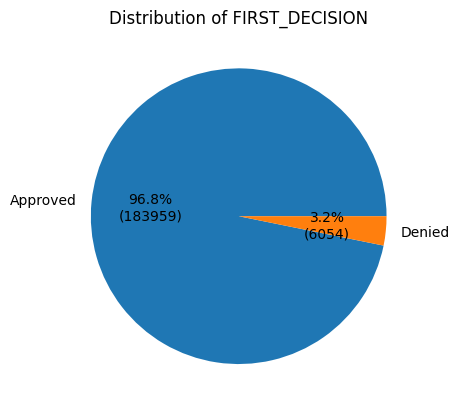

In [30]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))

        # Don't return anything if the percentage is less than ...
        if float('{:.1f}'.format(pct, v=val)) < 3:
            return None
        return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format

s = train_split_temp['FIRST_DECISION'].value_counts()
plt.pie(s,labels = s.index, autopct=autopct_format(s))
plt.title(f'Distribution of FIRST_DECISION')
plt.show()

### Summary statistics of our categorical and discrete features

In [31]:
categorical_features = [
    'gender', 
    'world_region_nationality', 
    'WORKSITE_REGION', 
    'NAICS_DESC', 
    'ED_LEVEL_DEFINITION'
]
display(train_split_temp[categorical_features].describe())
display(train_split_temp.describe())

,gender,world_region_nationality,WORKSITE_REGION,NAICS_DESC,ED_LEVEL_DEFINITION
count,190013,190013,190013,179233,190013
unique,2,7,5,21,10
top,male,Asia,West,"Professional, Scientific, and Technical Services",MASTER'S DEGREE
freq,127533,167959,59703,116191,90282


,WAGE_AMT_ANNUAL,ben_age_in_years
count,190013.000000,190013.000000
mean,0.366878,30.948893
std,1.837710,5.649947
min,-4.146789,19.000000
25%,-0.647064,27.000000
50%,0.018349,30.000000
75%,1.128440,34.000000
max,41.568578,65.000000


### Encode categorical features

In [32]:
def encode_categorical_features(train_df, val_df, test_df, features):
    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    for feature in features:
        # Initialize and fit OneHotEncoder
        enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        enc.fit(train_df[[feature]])  # Fit on training data

        # Transform each split
        train_encoded = enc.transform(train_df[[feature]])
        val_encoded = enc.transform(val_df[[feature]])
        test_encoded = enc.transform(test_df[[feature]])

        # Convert arrays to DataFrames
        train_onehot = pd.DataFrame(
            train_encoded, 
            columns=enc.get_feature_names_out([feature]), index=train_df.index
        )
        val_onehot = pd.DataFrame(
            val_encoded, 
            columns=enc.get_feature_names_out([feature]), index=val_df.index
        )
        test_onehot = pd.DataFrame(
            test_encoded, 
            columns=enc.get_feature_names_out([feature]), index=test_df.index
        )

        # Concatenate encoded features and drop original feature
        train_df_copy = pd.concat([train_df_copy, train_onehot], axis=1).drop(columns = feature)
        val_df_copy = pd.concat([val_df_copy, val_onehot], axis=1).drop(columns = feature)
        test_df_copy = pd.concat([test_df_copy, test_onehot], axis=1).drop(columns = feature)

    return train_df_copy, val_df_copy, test_df_copy

categorical_features = [
    'gender', 
    'world_region_nationality', 
    'WORKSITE_REGION', 
    'NAICS_DESC', 
    'ED_LEVEL_DEFINITION'
]
X_train, X_val, X_test = encode_categorical_features(X_train, X_val, X_test, categorical_features)

### Write train, val and test datasets to csv for ML modeling

In [33]:
# Replace Approved with 1 and Denied with 0
first_decision_mapping = {'Approved': 1, 'Denied': 0}

train_split = (X_train.merge(
        y_train, 
        left_index = True, 
        right_index = True
    )
    .dropna(subset = ['FIRST_DECISION'])
    .reset_index(drop = True)
)
train_split['FIRST_DECISION'] = train_split['FIRST_DECISION'].replace(first_decision_mapping)
train_split.to_csv('train_split.csv')

val_split = (X_val.merge(
        y_val, 
        left_index = True, 
        right_index = True
    )
    .dropna(subset = ['FIRST_DECISION'])
    .reset_index(drop = True)
)
val_split['FIRST_DECISION'] = val_split['FIRST_DECISION'].replace(first_decision_mapping)
val_split.to_csv('val_split.csv')

test_split = (X_test.merge(
        y_test, 
        left_index = True, 
        right_index = True
    )
    .dropna(subset = ['FIRST_DECISION'])
    .reset_index(drop = True)
)
test_split['FIRST_DECISION'] = test_split['FIRST_DECISION'].replace(first_decision_mapping)
test_split.to_csv('test_split.csv')

# Output sizes of splits
print("Training Set Size:", train_split.shape[0])
print("Validation Set Size:", val_split.shape[0])
print("Test Set Size:", test_split.shape[0])

Training Set Size: 190013
Validation Set Size: 93800
Test Set Size: 91090
